In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

## Data Preprocessing

### Address Missingness

In [3]:
# load in data
df_train = pd.read_csv('insurance_t.csv')
df_val = pd.read_csv('insurance_v.csv')

# Find columns with missing data in train and validation datasets
miss_t = [col for col in df_train.columns if df_train[col].isnull().sum() > 0]
miss_v = [col for col in df_val.columns if df_val[col].isnull().sum() > 0]

# Check if train and validation datasets are missing the same columns
print(miss_t == miss_v)

# Check what and how many values are missing in the train dataset
missing_counts_train = df_train[miss_t].isnull().sum()
print(missing_counts_train)

True
ACCTAGE     546
PHONE      1075
POS        1075
POSAMT     1075
INV        1075
INVBAL     1075
CC         1075
CCBAL      1075
CCPURC     1075
INCOME     1537
LORES      1537
HMVAL      1537
AGE        1702
CRSCORE     195
dtype: int64


In [4]:
# Define columns w/ missingness
continuous_cols = ["ACCTAGE", "PHONE", "POS", "POSAMT", "INVBAL", "CCBAL", "INCOME", "LORES", "HMVAL", "AGE", "CRSCORE"]
binary_cols = ["INV", "CC", "CCPURC"]

#replace ns's with 'Missing', 1's w/ 'Instance', 0' w/ 'Non-Instance' for train and val
for col in binary_cols:
    df_train[col] = df_train[col].replace({1: 'Instance', 0: 'Non-Instance'}).fillna('Missing')
    df_val[col] = df_val[col].replace({1: 'Instance', 0: 'Non-Instance'}).fillna('Missing')


#impute with median and create binary flag column
for col in continuous_cols:
    median_value = df_train[col].median()
    # Create a binary flag variable for imputation
    df_train[f'{col}_imputed'] = df_train[col].isnull().astype(int)
    #impute the missing values with the median
    df_train[col].fillna(median_value)

#do the same for val
for col in continuous_cols:
    median_value = df_train[col].median()
    # Create a binary flag variable for imputation
    df_val[f'{col}_imputed'] = df_val[col].isnull().astype(int)
    #impute the missing values with the median
    df_val[col].fillna(median_value)

### One-Hot Encode

In [5]:
# Separate binary columns and categorical columns for one-hot encoding
binary_columns = [
    "INAREA", "SDB", "MM", "IRA", "CD", "ATM", "SAV", "NSF", "DIRDEP", "DDA", "ACCTAGE_imputed", "PHONE_imputed", "POS_imputed", 
    "POSAMT_imputed", "INVBAL_imputed", "CCBAL_imputed", 
    "INCOME_imputed", "LORES_imputed", "HMVAL_imputed", 
    "AGE_imputed", "CRSCORE_imputed"
]

categorical_columns = [
    "INV", "CC", "CCPURC", "BRANCH"
]

# Apply one-hot encoding only to the specified categorical columns
df_train = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)
df_val = pd.get_dummies(df_val, columns=categorical_columns, drop_first=True)

# Label encode the MMCRED column in both datasets
label_encoder = LabelEncoder()
df_train['MMCRED'] = label_encoder.fit_transform(df_train['MMCRED'])
df_val['MMCRED'] = label_encoder.transform(df_val['MMCRED'])

# Ensure both train and validation have the same columns
df_val = df_val.reindex(columns=df_train.columns, fill_value=0)

# Convert binary columns to 0/1 (if needed)
for col in binary_columns:
    df_train[col] = df_train[col].astype(int)
    df_val[col] = df_val[col].astype(int)

In [6]:
# Define X as all columns except 'INS' and y as the 'INS' column
X_train = df_train.drop(columns=['INS'])
y_train = df_train['INS']

X_val = df_val.drop(columns=['INS'])
y_val = df_val['INS']

## Random Forest Model

### Hyperparameter Tuning

In [7]:
# define the rf estimator
rf = RandomForestClassifier(random_state = 88)

# RandomsearchCV Parameters
from sklearn.model_selection import RandomizedSearchCV
# number of trees (estimators/weak models) in Bagging
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 100)]
# number of features to consider at every split
max_features = ['sqrt', 'log2']
# minimum number of samples at leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# Create the random grid
random_params = {'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'min_samples_leaf': min_samples_leaf}

In [41]:
rf_gs = RandomizedSearchCV(estimator = rf, param_distributions = random_params,
                           n_iter = 100, cv = 3, verbose = 1, random_state=88)

# Fit the random search model
rf_gs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=88),
                   n_iter=100,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   random_state=88, verbose=1)

In [42]:
rf_gs.best_params_

{'n_estimators': 770,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 90}

### Variable Tuning

In [12]:
#add in an uncorrelated and random x
X_train_r = X_train
X_train_r['random'] = np.random.normal(0, 1, X_train.shape[0])

In [13]:
#Fit model with the random variable using best parameters from above RandomGridSearch
best_rf = RandomForestClassifier(n_estimators=770,min_samples_leaf=2,max_features='sqrt', max_depth=90, random_state = 88, oob_score=True)
best_rf.fit(X_train_r,y_train)

RandomForestClassifier(max_depth=90, min_samples_leaf=2, n_estimators=770,
                       oob_score=True, random_state=88)

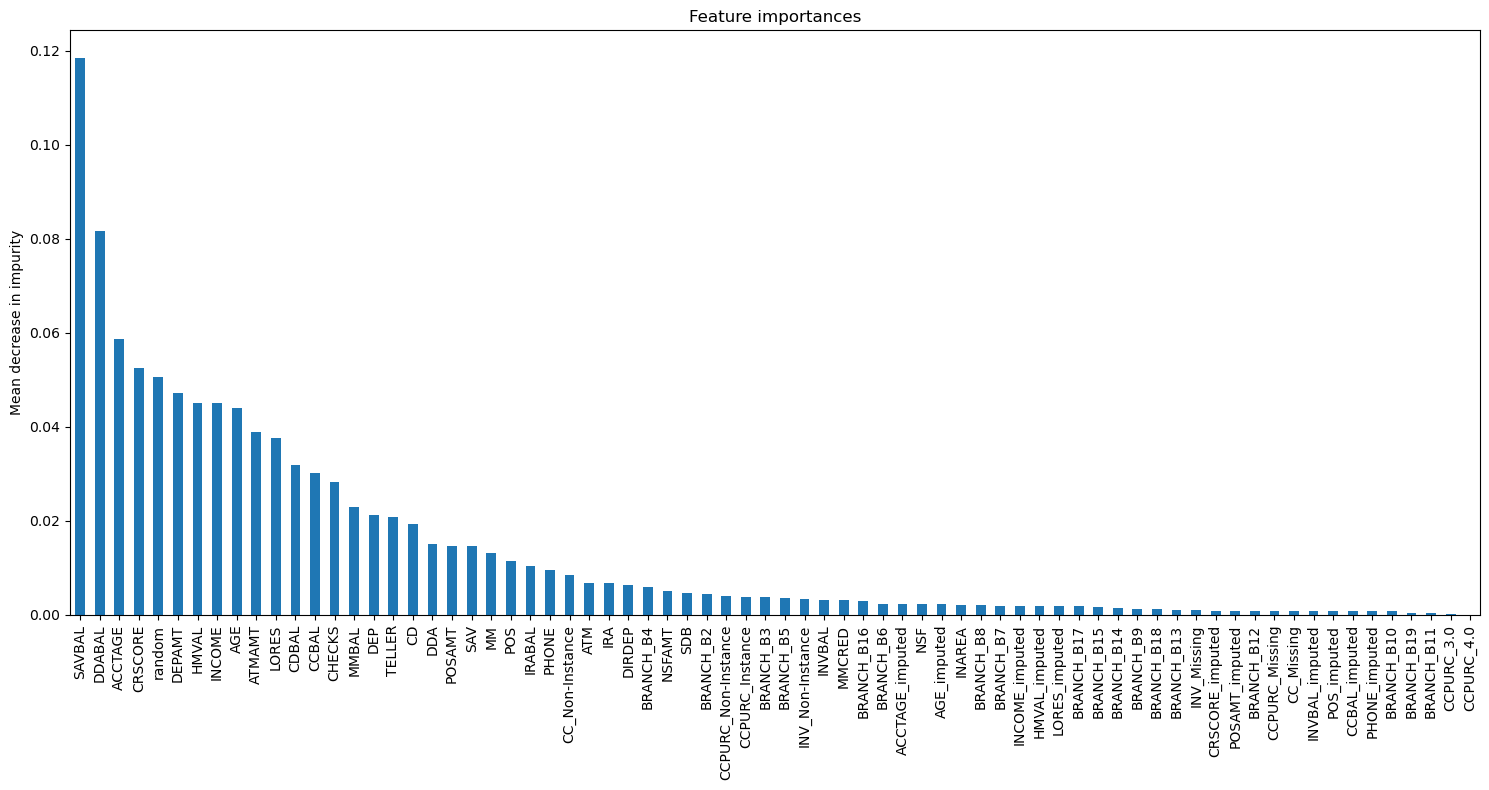

In [ ]:
#grab the most important feature
forest_importances = pd.Series(best_rf.feature_importances_, index = best_rf.feature_names_in_).sort_values(ascending=False)

#plot the most important features
fig, ax = plt.subplots(figsize=(15, 8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [21]:
forest_importances

SAVBAL        0.118457
DDABAL        0.081726
ACCTAGE       0.058619
CRSCORE       0.052514
random        0.050552
                ...   
BRANCH_B10    0.000748
BRANCH_B19    0.000423
BRANCH_B11    0.000398
CCPURC_3.0    0.000269
CCPURC_4.0    0.000008
Length: 72, dtype: float64

We see that SAVBAL, DDABAL, ACCTAGE, CRSCORE are the vars more infulential than a random x.

### Retraining RF Model w/ The Important Features  
SAVBAL, DDABAL, ACCTAGE, CRSCORE

In [26]:
X_train_new = X_train[['SAVBAL', 'DDABAL', 'ACCTAGE', 'CRSCORE']]
X_val_new = X_val[['SAVBAL', 'DDABAL', 'ACCTAGE', 'CRSCORE']]

# Fit the random search model w/ the same grid search as before
rf_gs = RandomizedSearchCV(estimator = rf, param_distributions = random_params,
                           n_iter = 100, cv = 3, verbose = 1, random_state=88)
rf_gs.fit(X_train_new, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 